In [1]:
# Initial imports
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import wrangle
import explore

import sys
import os
from env import username, api_key, download_kaggle_file

home_directory_path = os.path.expanduser('~')
sys.path.append(home_directory_path +'/utils')

import wrangle_utils as w
import explore_utils as e
import model_utils as m
import env

import warnings
warnings.filterwarnings("ignore")

#
# Acquire

In [2]:
df = wrangle.acquire_superstore()

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


#
# Prepare

In [4]:
df = w.normalize_column_names(df)

In [5]:
df.duplicated().sum()

0

In [6]:
explore.check_nulls_duplicates(df)

There are 0 nulls in the dataset.
There are 0 duplicates in the dataset.


In [7]:
df.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [8]:
df.country.unique()

array(['United States'], dtype=object)

In [9]:
df = df[['customer_id', 'order_date', 'segment', 'state', 'region', 'product_id', 'category', 'sales', 'quantity', 'discount', 'profit']]

In [10]:
df.head()

,customer_id,order_date,segment,state,region,product_id,category,sales,quantity,discount,profit
0,CG-12520,11/8/2016,Consumer,Kentucky,South,FUR-BO-10001798,Furniture,261.9600,2,0.00,41.9136
1,CG-12520,11/8/2016,Consumer,Kentucky,South,FUR-CH-10000454,Furniture,731.9400,3,0.00,219.5820
2,DV-13045,6/12/2016,Corporate,California,West,OFF-LA-10000240,Office Supplies,14.6200,2,0.00,6.8714
3,SO-20335,10/11/2015,Consumer,Florida,South,FUR-TA-10000577,Furniture,957.5775,5,0.45,-383.0310
4,SO-20335,10/11/2015,Consumer,Florida,South,OFF-ST-10000760,Office Supplies,22.3680,2,0.20,2.5164


In [11]:
df = w.date_set_index(df, 'order_date')

In [12]:
# Make the frequency columns

category = pd.get_dummies(df.category, drop_first=True)
region = pd.get_dummies(df.region, drop_first=True)
segment = pd.get_dummies(df.segment, drop_first=True)
region = pd.get_dummies(df.region, drop_first=True)

test = pd.concat([category, region, segment], axis=1)

In [13]:
test = w.normalize_column_names(test)

In [21]:
test.head()

,office_supplies,technology,east,south,west,corporate,home_office
date,,,,,,,
2014-01-03,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2014-01-04,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
2014-01-05,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
2014-01-06,0.666667,0.222222,0.0,0.888889,0.111111,0.111111,0.777778
2014-01-07,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [14]:
# Resample by day

test = test.resample("D").mean()

In [23]:
test.shape

(1458, 7)

In [15]:
test.index.max() - test.index.min()

Timedelta('1457 days 00:00:00')

In [16]:
test.shape

(1458, 7)

In [17]:
# Resample the original df by day

df = df.resample("D").sum()
df.head()

,sales,quantity,discount,profit
date,,,,
2014-01-03,16.448,2,0.2,5.5512
2014-01-04,288.060,8,1.2,-65.9901
2014-01-05,19.536,3,0.2,4.8840
2014-01-06,4407.100,30,0.0,1358.0524
2014-01-07,87.158,10,1.4,-71.9621


In [22]:
df.shape

(1458, 4)

In [24]:
df = pd.concat([df, test], axis=1)

In [25]:
df.head()

,sales,quantity,discount,profit,office_supplies,technology,east,south,west,corporate,home_office
date,,,,,,,,,,,
2014-01-03,16.448,2,0.2,5.5512,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2014-01-04,288.060,8,1.2,-65.9901,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
2014-01-05,19.536,3,0.2,4.8840,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
2014-01-06,4407.100,30,0.0,1358.0524,0.666667,0.222222,0.0,0.888889,0.111111,0.111111,0.777778
2014-01-07,87.158,10,1.4,-71.9621,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [28]:
train = df

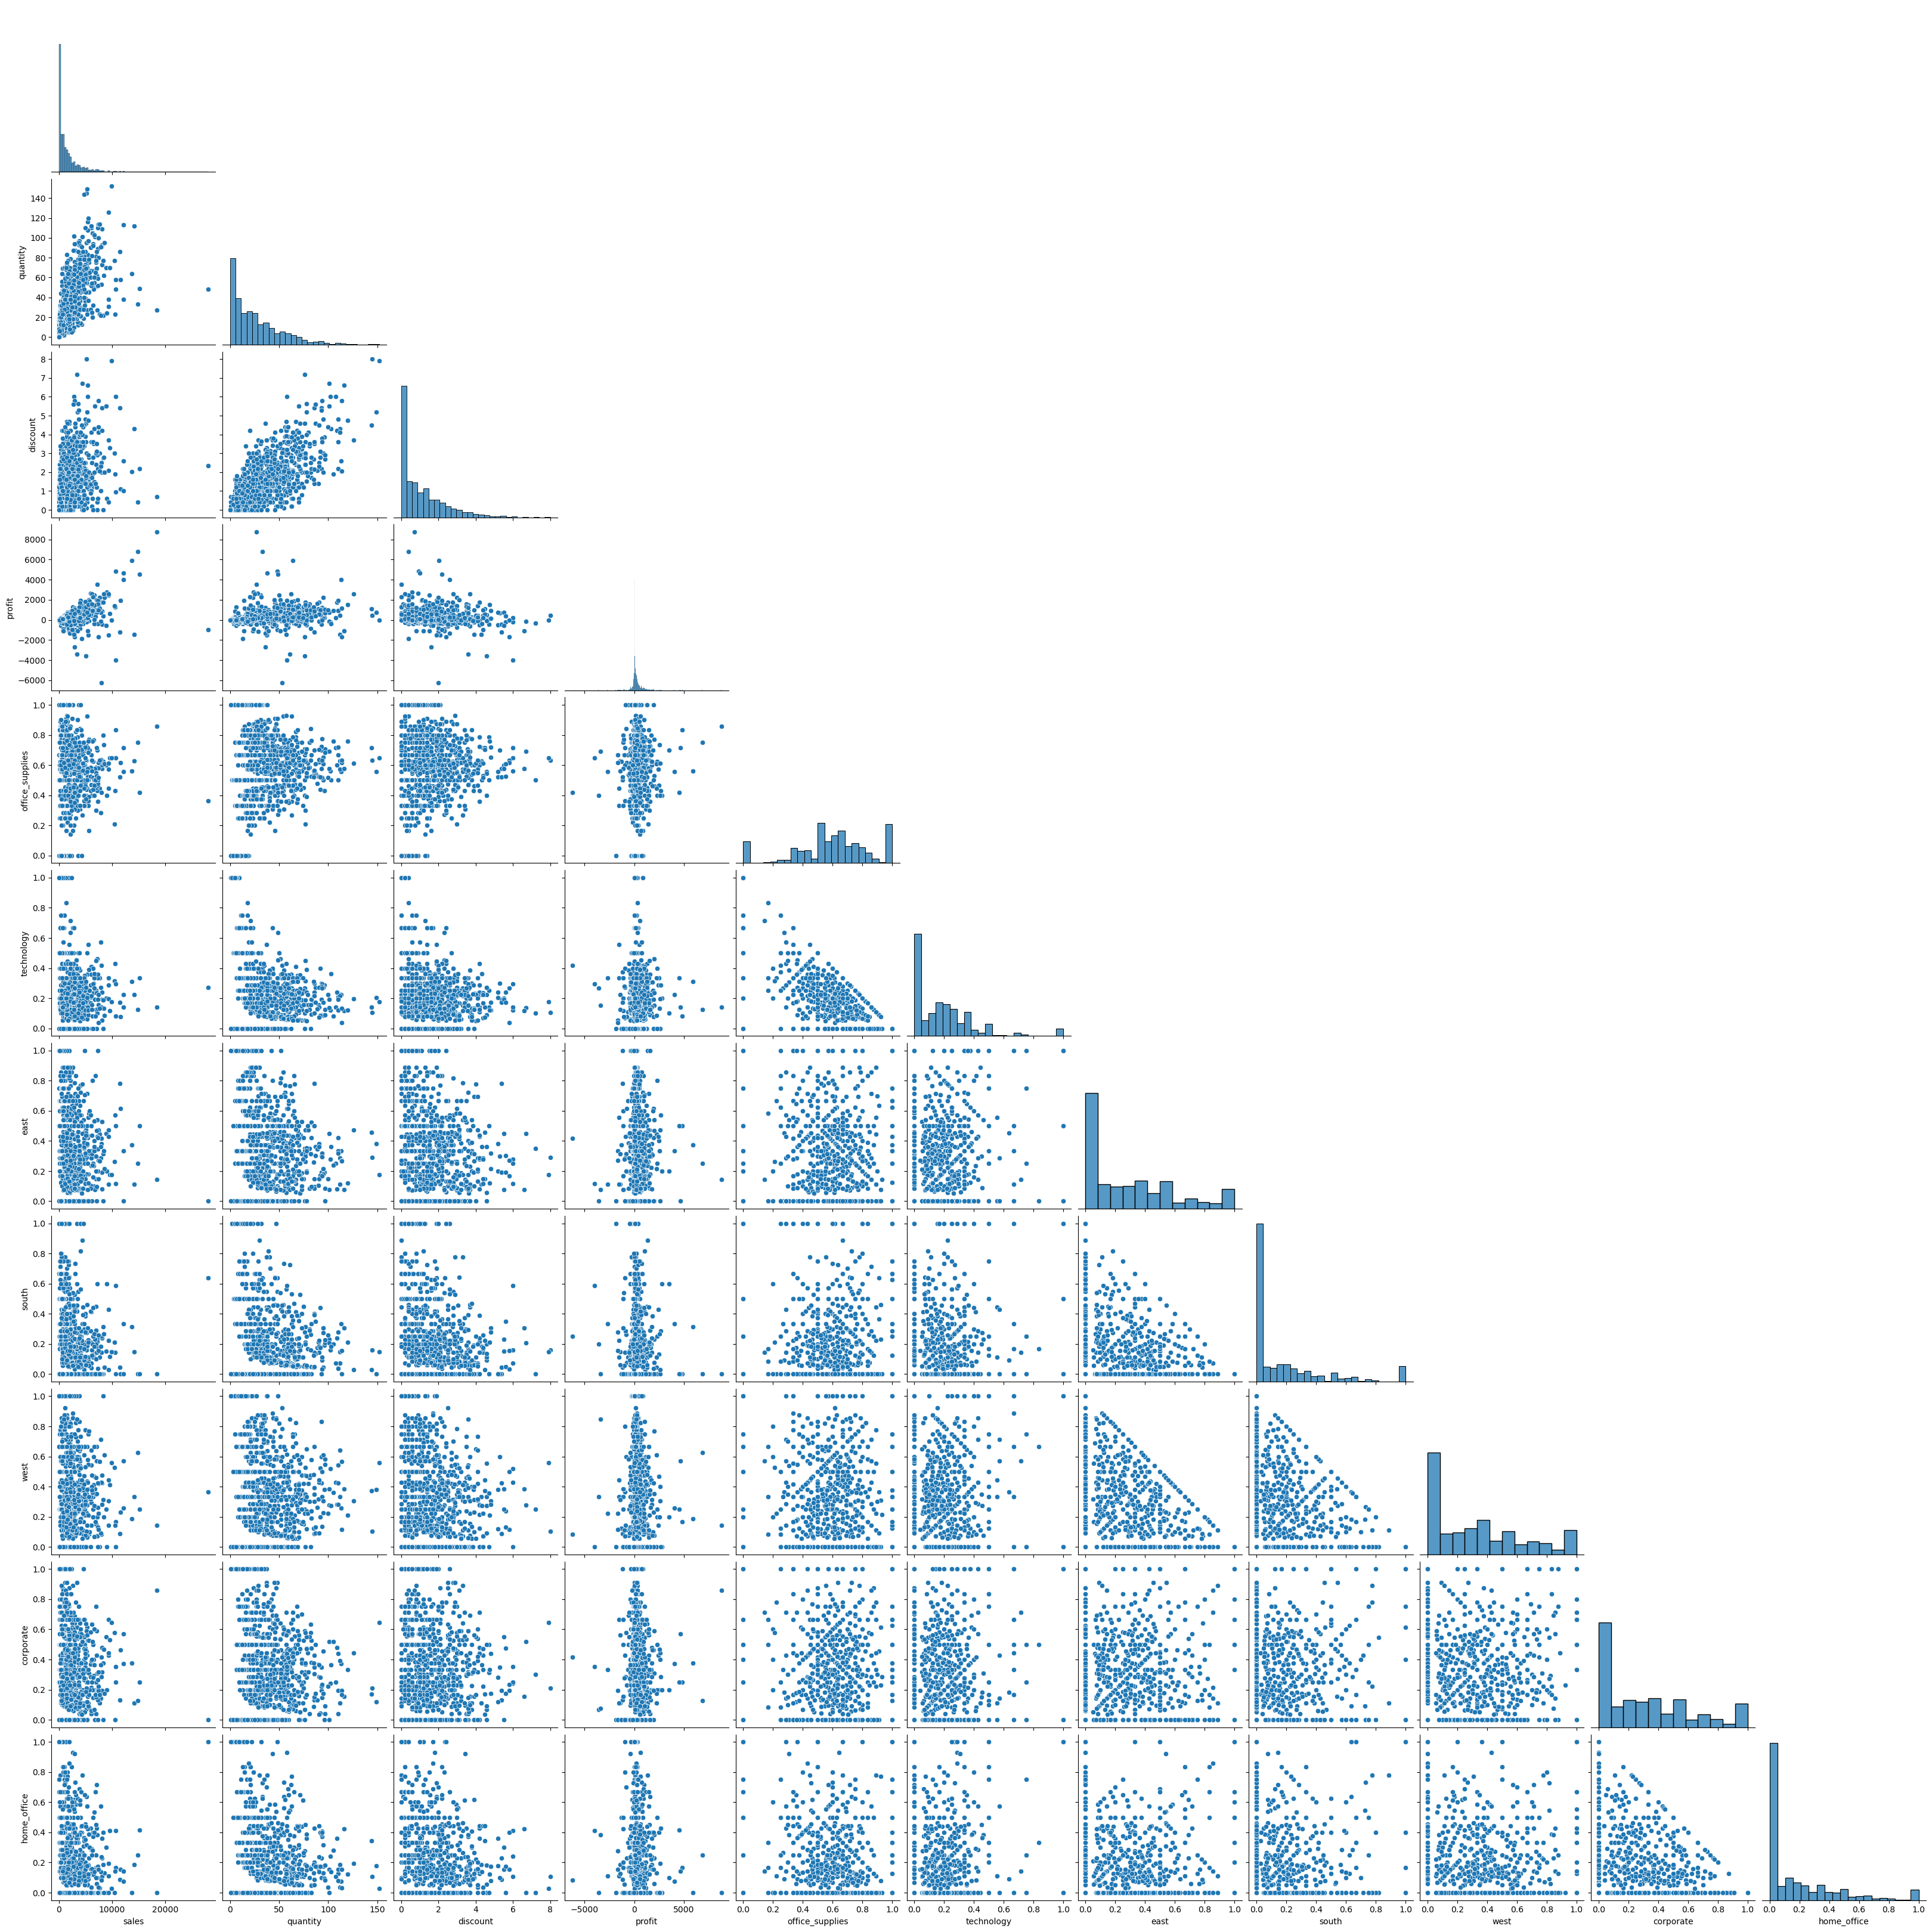

In [29]:
sns.pairplot(train,height=3, corner=True)

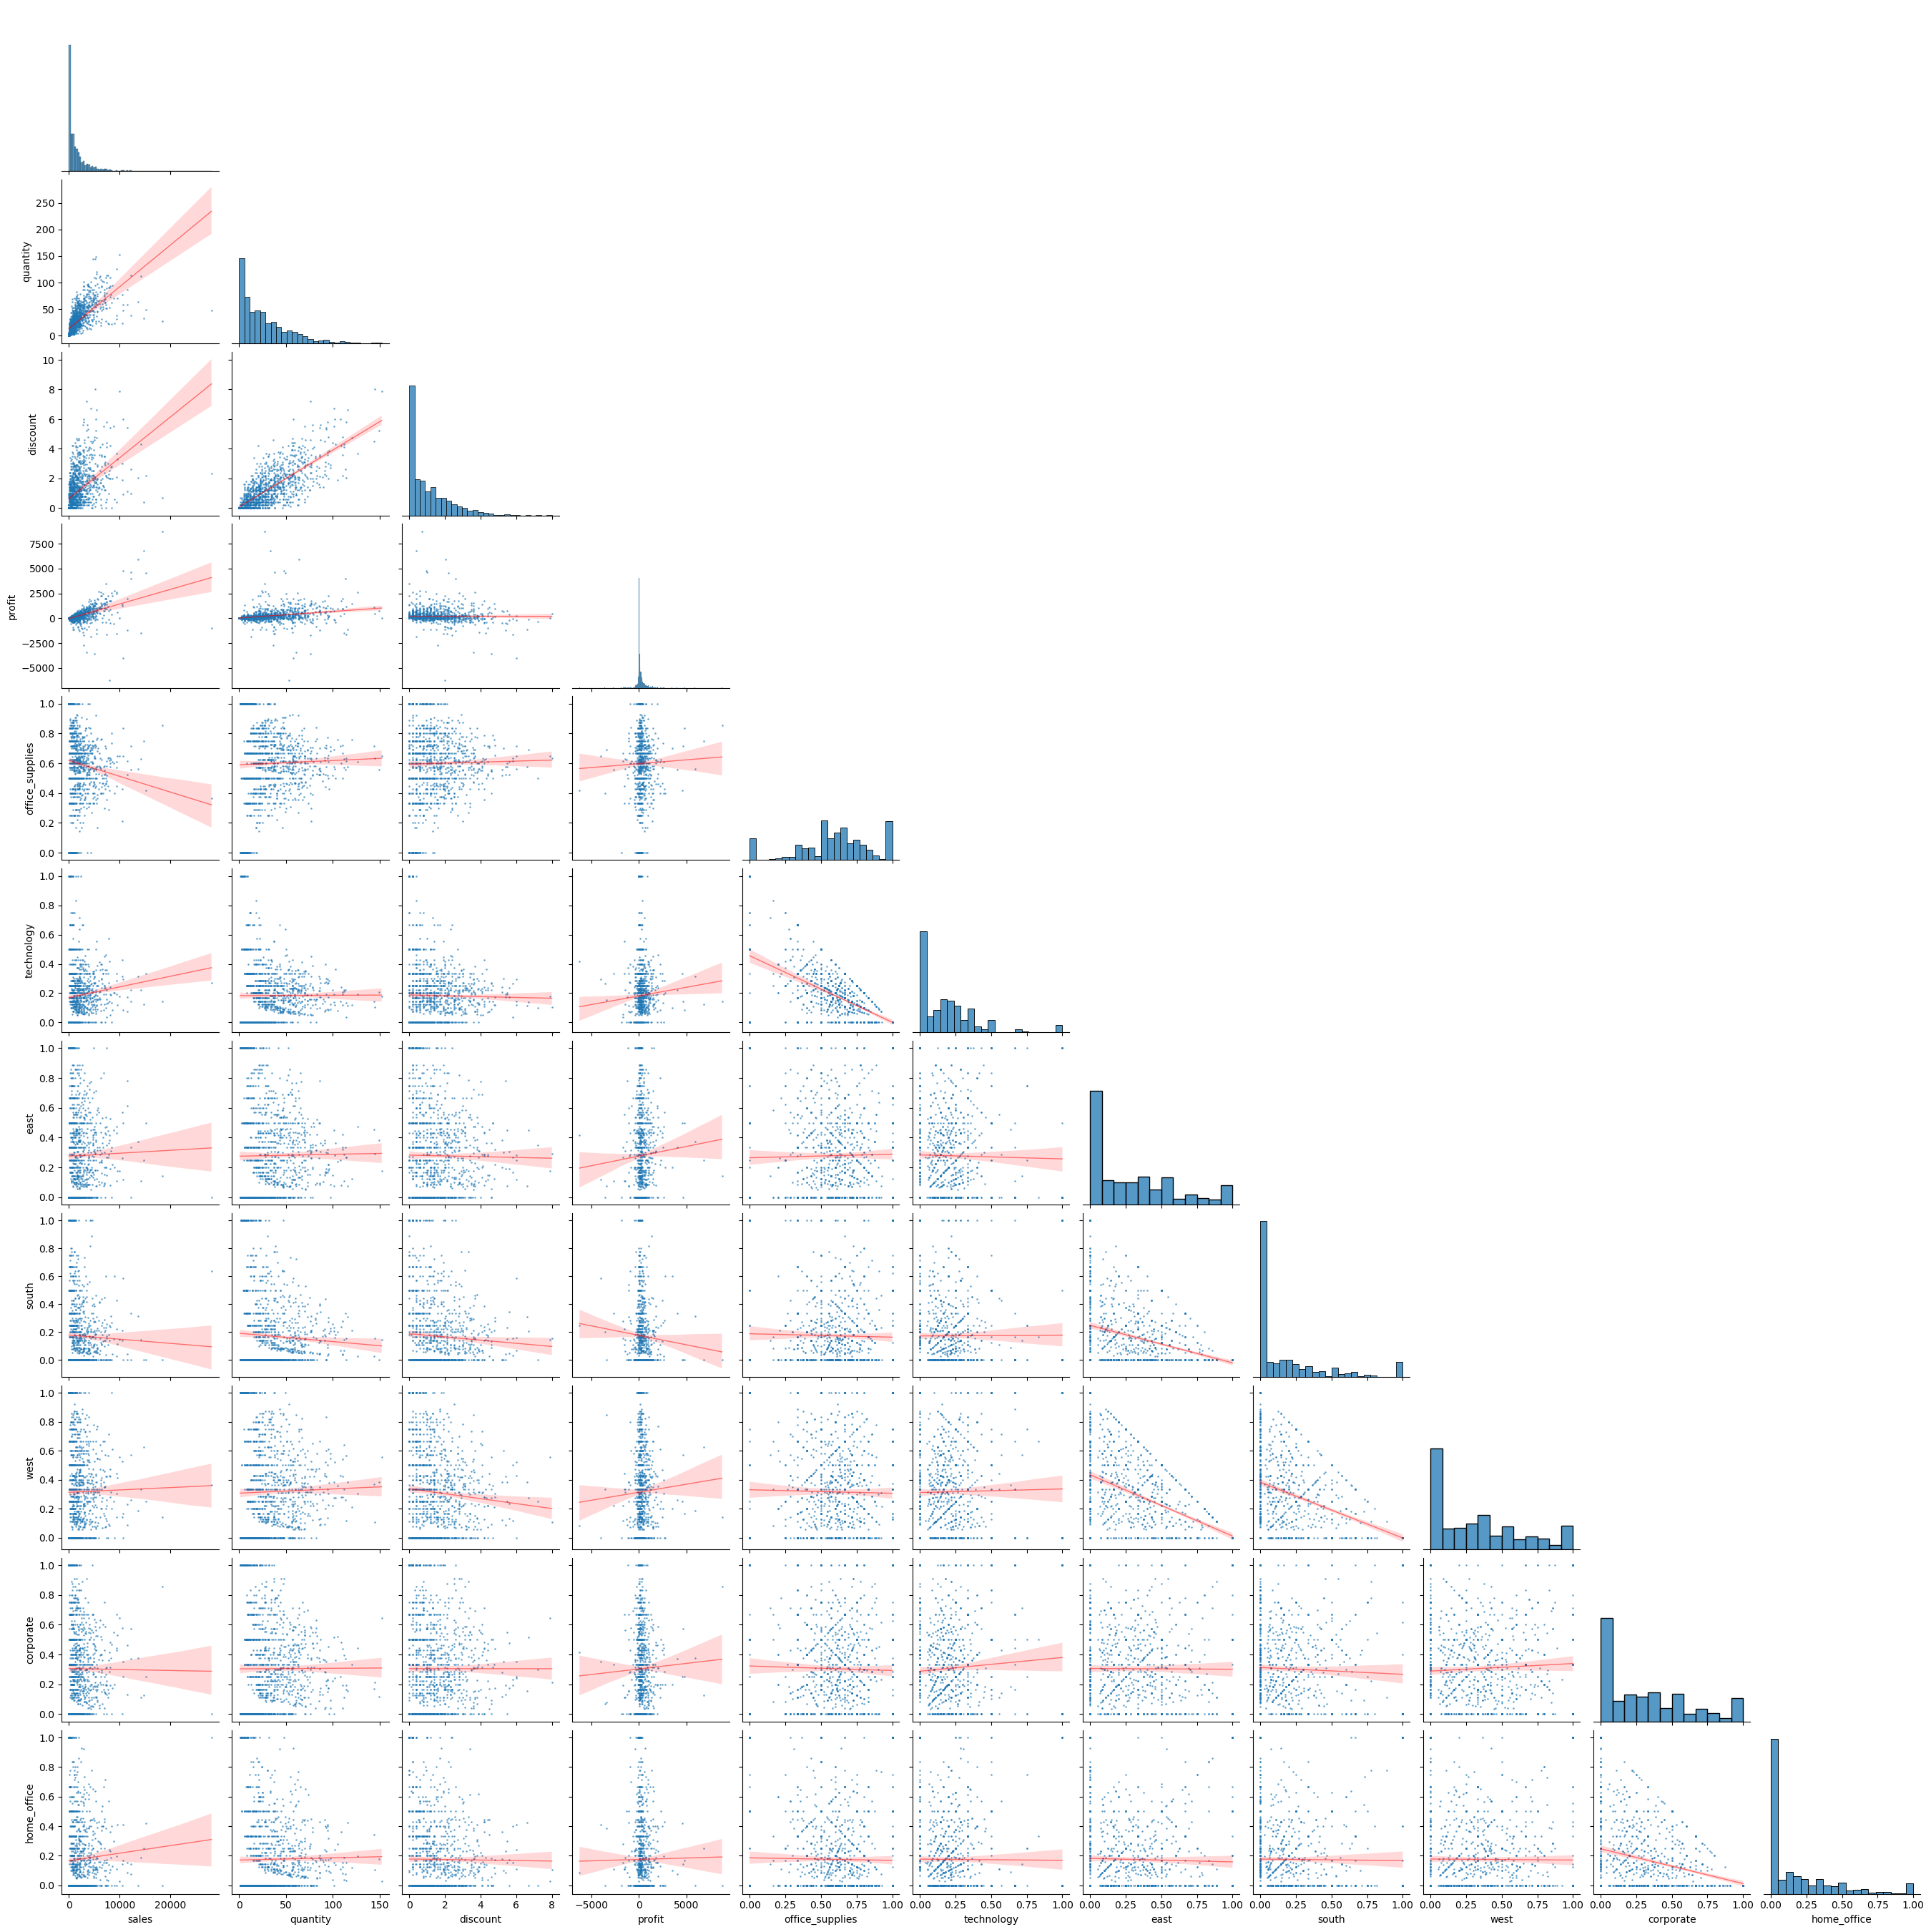

NameError: name 'train' is not defined

In [30]:
e.explore_bivariate_cont_to_cont_target(train, 'sales')

## Findings: 
## discount and quantity are highly related
## office supplies is related to quantity and discount
## office supplies and sales

In [20]:
category = pd.get_dummies(df.category, drop_first=True)
region = pd.get_dummies(df.region, drop_first=True)
segment = pd.get_dummies(df.segment, drop_first=True)
region = pd.get_dummies(df.region, drop_first=True)

test = pd.concat([category, region, segment], axis=1)

AttributeError: 'DataFrame' object has no attribute 'category'

In [ ]:
frequency_cols = test.resample("W").mean()

In [ ]:
df = pd.concat([df, frequency_cols])
df= w.normalize_column_names(df)
df.head()

In [ ]:
test.resample('W').mean()

#
# Explore

In [ ]:
df = w.date_set_index(df, 'order_date')

In [ ]:
df = df.sort_index()

In [ ]:
df.resample("3M").sum()

In [ ]:
sales_df = pd.DataFrame(df['sales'])

In [ ]:
profit_df = pd.DataFrame(df['profit'])
profit_df

In [ ]:
sales_df = sales_df.sort_index()

In [ ]:
profit_df = profit_df.sort_index()

In [ ]:
profit_df = profit_df.resample("D").agg("sum")

In [ ]:
profit_df.shape

In [ ]:
profit_df.plot()

In [ ]:
# Split into train, validate, test (70/15/15)
train_size = .70
#val_size = .85
n = sales_df.shape[0]
test_start_index = round(train_size * n)
# val_start_index = round(val_size * n)

train = sales_df[:test_start_index] # everything up (not including) to the test_start_index
test = sales_df[test_start_index:] # everything from the test_start_index to the end
# validate = test[:val_start_index]
# test = test[val_start_index:]

plt.plot(train.index, train.sales)
# plt.plot(validate.index, validate.profit)
plt.plot(test.index, test.sales)


In [ ]:
# Split into train, validate, test (70/15/15)
train_size = .70
#val_size = .85
n = profit_df.shape[0]
test_start_index = round(train_size * n)
# val_start_index = round(val_size * n)

train = profit_df[:test_start_index] # everything up (not including) to the test_start_index
test = profit_df[test_start_index:] # everything from the test_start_index to the end
# validate = test[:val_start_index]
# test = test[val_start_index:]

plt.plot(train.index, train.profit)
# plt.plot(validate.index, validate.profit)
plt.plot(test.index, test.profit)


In [ ]:
pd.plotting.autocorrelation_plot(train.sales)

In [ ]:
pd.plotting.autocorrelation_plot(train.profit)

#### Findings:
#### Neither profit or sales have an autocorrelation. This project will have to rely on regression analysis from this point on #####

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df = df.drop(columns=['discount', 'quantity', 'profit'])

In [ ]:
df = df.reset_index().drop(columns='date')

In [ ]:
df.head()

In [ ]:
df.product_id.nunique()

In [ ]:
df.groupby('segment').agg('mean').sales.mean()

In [ ]:
e.explore_bivariate_cat_to_cont_target(df,'sales', cat_cols=['segment', 'state', 'region', 'category'])


In [ ]:
# investigate state relationships with sales
df.groupby('region').agg('sum').sort_values('sales', ascending=False)

In [ ]:
dums = pd.get_dummies(df.region)
dums

In [ ]:
dums['sales'] = df.sales

In [ ]:
# investigate state relationships with sales
df.groupby('state').agg('sum').sort_values('sales',ascending=False)

#
## Findings:
- consumer and home office segments may relate to sales
-  

In [ ]:
# Make a column that represents the aggregated values of feature columns over the last three months

In [ ]:
df.head()

In [ ]:
def prep_superstore(df):
    df = w.normalize_column_names(df)

In [ ]:
def check_nulls_duplicates(df):
    print(f'There are {df.isnull().sum().sum()} nulls in the dataset.')
    print(f'There are {df.duplicated.sum()} nulls in the dataset.')

In [ ]:
def acquire_superstore():
    ''' This function checks to see if a csv with the zillow dataset exists, and if not, runs a SQL query to pull from database and save it in a new csv file.'''
    
    filename = 'superstore.csv'

    if os.path.isfile(filename):
        return pd.read_csv(filename)

    else:
        print('File does not exist. Download from https://www.kaggle.com/datasets/vivek468/superstore-dataset-final/download?datasetVersionNumber=1')